## Import modules

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation

import pickle
import os
import glob
import re
import cv2 as cv 


## Import icewave modules

In [153]:
# auto reload modules 
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:/Users/sebas/git')

import icewave.tools.matlab_colormaps as matcmaps
import icewave.tools.Fourier_tools as FT

# PARULA COLORMAP 
parula_map = matcmaps.parula()

plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [154]:
def lorentzian(x,x0,alpha):
    y = 1/np.sqrt(1 + ((x - x0)/alpha)**2)
    return y


def get_suffixe(data):
    """ Create suffixe for image and file name definition """

    f_ex = data['f_ex']
    amplitude = data['amplitude']
    suffixe = f'f_ex_{f_ex}Hz_amp_{amplitude}mm'
    suffixe = suffixe.replace('.','p')
    
    return suffixe

def save_first_frame(data,results_folder):
    """ Save first frame of surface deformation"""
    suffixe = get_suffixe(data)
    
    fig, ax = plt.subplots()
    ax.plot(data['x']*1e2,data['spatio'][:,0]*1e3)
    ax.set_xlabel(r'$x \; \mathrm{(cm)}$',labelpad = 5)
    ax.set_ylabel(r'$\xi \; \mathrm{(mm)}$',labelpad = 5)
    
    figname = f'{results_folder}xi_t0_{suffixe}'
    plt.savefig(figname + '.pdf', bbox_inches='tight')
    plt.savefig(figname + '.png', bbox_inches='tight')
    plt.close(fig)
    
def FFT2D_positive_freq(spatio,facq):
    """ Compute FFT2 of spatio-temporal signal, and keep only part with positive frequency
    """
    shift,k,omega = FT.fft_2D(spatio,facq)
    freq = omega/2/np.pi
    
    positive_shift = shift[:,shift.shape[1]//2:]
    positive_freq = freq[len(freq)//2:]
    
    return positive_shift,k,positive_freq

def save_FFT2D_with_max(positive_shift,k,positive_freq,unravel_coords,figname):
    
    """ Save FFT2D figure of spatio-temporal signal, with observed maximum """
    
    fig, ax = plt.subplots(figsize = (12,9))
    c = ax.imshow(abs(positive_shift).T*1e3,cmap = parula_map,aspect = 'auto',norm = 'linear',origin = 'lower',
                  interpolation = 'gaussian', extent = (k.min(),k.max(),positive_freq.min(),positive_freq.max()))
    
    ax.set_ylim([0,6])
    ax.set_xlim([-500,500])
    ax.plot(k[unravel_coords[0]],positive_freq[unravel_coords[1]],'ro')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    
    cbar = plt.colorbar(c,cax = cax)
    cbar.set_label(r'$\hat{\xi} (k_x,f) \; \mathrm{(mm)}$',labelpad = 1)
    
    ax.set_xlabel(r'$k_x \; \mathrm{(rad.m^{-1})}$',labelpad = 5)
    ax.set_ylabel(r'$f \; \mathrm{(Hz)}$',labelpad = 5)
    
    plt.savefig(figname + '.pdf', bbox_inches='tight')
    plt.savefig(figname + '.png', bbox_inches='tight')
    plt.close(fig)
    return 


def lorentzian_fit(cut,k,k0_idx,bounds_alpha):
    """ Perform Lorentzian fit along a profile. 
    Inputs : - cut, 1D numpy array, profile along which lorentzian fit must be performed
             - k, 1D numpy array or list, list of wavevectors
             - k0_idx, index of initial guess for center of lorentzian
             - bounds_alpha, boundaries between which lorentzian width must be checked """
    
    y_exp = (cut - cut.min())/(cut.max() - cut.min())

    bounds_kx0 = (k[k0_idx - 10],k[k0_idx + 10])
    bounds_curvefit = ([bounds_kx0[0],bounds_alpha[0]],[bounds_kx0[1],bounds_alpha[1]])
    # fit by a lorentzian
    popt,pcov = scipy.optimize.curve_fit(lambda x,x0,sigma : lorentzian(x, x0, sigma),k,y_exp,
                                         bounds = bounds_curvefit)
    err_coeff = np.sqrt(np.diag(pcov))
    
    return popt,err_coeff

def save_lorentzian_plot(cut,k,popt,figname):
    """ Save lorentzian plot """
    
    label_fit = r'$\alpha = ' + f'{popt[1]:.1f}' + '\; \mathrm{(m^{-1})}$'
    print(label_fit)
    k_fit = np.linspace(k.min(),k.max(),4000)
    yth = lorentzian(k_fit,popt[0],popt[1])*(cut.max() - cut.min()) + cut.min()
    
    fig, ax = plt.subplots()
    ax.plot(k,cut*1e3,'o-')
    ax.plot(k_fit,yth*1e3,'r',label = label_fit)
    ax.legend()
    
    ax.set_xlabel(r'$k_x \; \mathrm{(rad.m^{-1})}$',labelpad = 5)
    ax.set_ylabel(r'$|\hat{\xi}|(k_x) \; \mathrm{(mm)}$',labelpad = 5)
    ax.set_xlim([-500,500])
    plt.savefig(figname + '.pdf', bbox_inches='tight')
    plt.savefig(figname + '.png', bbox_inches='tight')
    plt.close(fig)
    return 

def process_single_experiment(data,main_results_folder):
    """ Perform all processes for a single experiment and save data associated to attenuation """

    f_ex = data['f_ex']
    amplitude = data['amplitude']
    ID = f'{f_ex}Hz_{amplitude}mm'
    ID = ID.replace('.','p')
    
    results_folder = f'{main_results_folder}{ID}/'  
    if not os.path.isdir(results_folder):
        os.mkdir(results_folder)
     
    # save first frame 
    save_first_frame(data,results_folder)
    
    # Compute FFT2D
    positive_shift,k,positive_freq = FFT2D_positive_freq(data)
    
    # find maximum
    idx_max = np.argmax(abs(positive_shift).flatten())
    unravel_coords = np.unravel_index(idx_max,positive_shift.shape)
    
    # Plot 
    suffixe = get_suffixe(data)
    figname = f'{results_folder}FFT2D_{suffixe}'
    save_FFT2D_with_max(positive_shift, k, positive_freq, unravel_coords, figname)
    
    # Fit cut for a given frequency by a lorentzian
    cut = abs(positive_shift)[:,unravel_coords[1]]
    bounds_alpha = (0,1e2)
    popt,err_coeff = lorentzian_fit(cut,k,unravel_coords[0],bounds_alpha)
    
    figname = f'{results_folder}Lorentzian_fit_{suffixe}'
    save_lorentzian_plot(cut,k,popt,figname)
    
    # save results 
    dict_res = {}
    dict_res['f_demod'] = positive_freq[unravel_coords[1]]
    dict_res['k0'] = abs(popt[0])
    dict_res['err_k0'] = abs(err_coeff[0])
    dict_res['alpha'] = popt[1]
    dict_res['err_alpha'] = abs(err_coeff[1])
    dict_res['lorentz'] = {}
    dict_res['lorentz']['kx'] = k
    dict_res['lorentz']['y'] = cut
    dict_res['param'] = data['param']
    dict_res['h'] = data['h']
    dict_res['f_ex'] = data['f_ex']
    dict_res['amplitude'] = data['amplitude']
    dict_res['ID'] = ID
    
    file2save = f'{results_folder}laser_attenuation_{suffixe}.pkl'
    with open(file2save,'wb') as pf:
        pickle.dump(dict_res,pf)
    
    print(f'Attenuation data saved under name : {file2save}')
    return

## Import data

In [172]:
h = 2.5 # thickness in mm
date = '2024_07_10'
main_path = f'U:/Aurore_frasil/{date}_e_{h}mm_laser/'
path2data = f'{main_path}Laser_extraction/'
filelist = glob.glob(f'{path2data}scaled_laser_structure*')

main_results_folder = f'{main_path}Laser_attenuation/'
if not os.path.isdir(main_results_folder):
    os.mkdir(main_results_folder)

idx = 0
file2load = filelist[idx]
with open(file2load,'rb') as pf:
    data = pickle.load(pf)

f_ex = data['f_ex']
print(f'f_ex = {f_ex} Hz')

f_ex = 3.0 Hz


## Show frame 

Text(0, 0.5, '$\\xi \\; \\mathrm{(mm)}$')

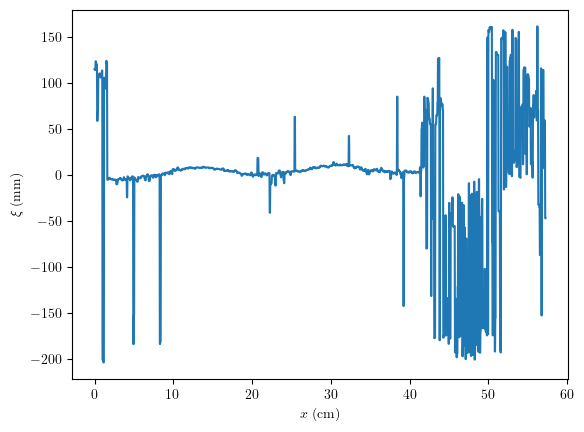

In [173]:
fig, ax = plt.subplots()
ax.plot(data['x']*1e2,data['spatio'][:,0]*1e3)
ax.set_xlabel(r'$x \; \mathrm{(cm)}$',labelpad = 5)
ax.set_ylabel(r'$\xi \; \mathrm{(mm)}$',labelpad = 5)


### Show spatio-temporal

(0.0, 5.0)

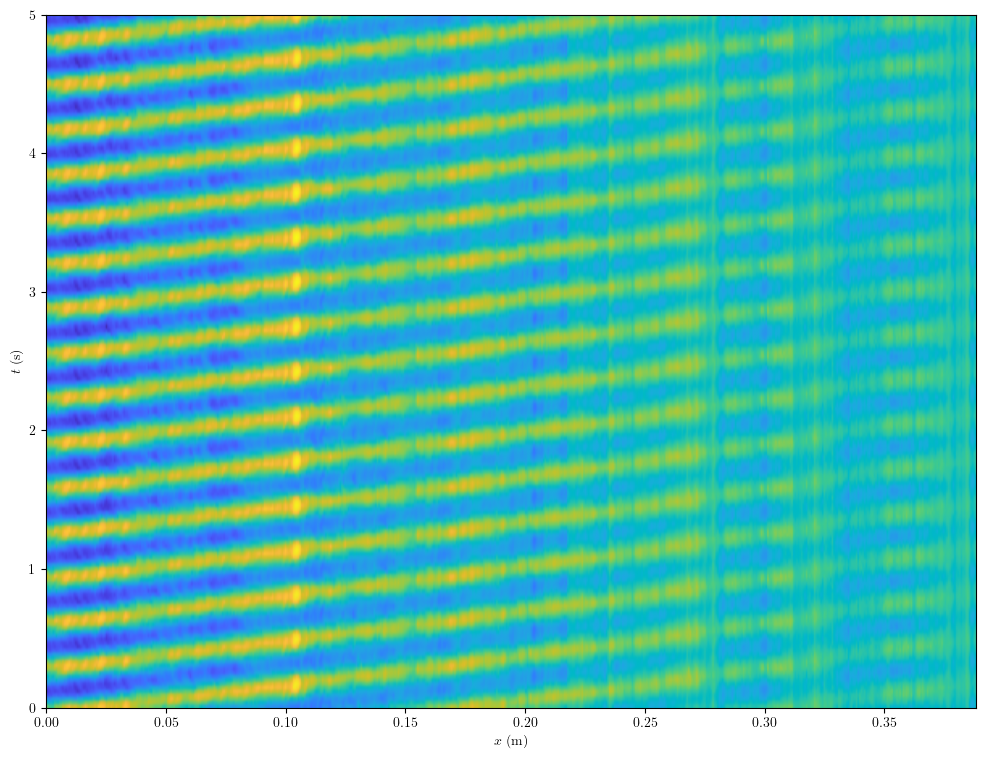

In [145]:
fig,ax = plt.subplots(figsize = (12,9))
x = data['x']
t = data['t']

ax.imshow(data['spatio'].T,origin = 'lower', interpolation = 'gaussian',cmap = parula_map,norm = 'linear', aspect = 'auto',
          extent = (x.min(),x.max(),t.min(),t.max()))
ax.set_xlabel(r'$x \; \mathrm{(m)}$')
ax.set_ylabel(r'$t \; \mathrm{(s)}$')
ax.set_ylim([0,5])

### Perform 2D FFT 

In [80]:
data.keys()

dict_keys(['spatio', 'x', 't', 'param', 'SCALE', 'h', 'f_ex', 'amplitude'])

In [146]:
# Compute FFT2D
facq = [data['SCALE']['facq_pix'],data['SCALE']['facq_t']]
shift,k,freq = FFT2D_positive_freq(data['spatio'],facq)

# keep frequencies higher than threshold
threshold_freq = 0.5
mask = freq > threshold_freq
positive_freq = freq[mask]
positive_shift = shift[:,mask]

# find maximum
idx_max = np.argmax(abs(positive_shift).flatten())
unravel_coords = np.unravel_index(idx_max,positive_shift.shape)

[2048, 1024]


f_demod = 3.0891357421875 Hz


Text(0, 0.5, '$f \\; \\mathrm{(Hz)}$')

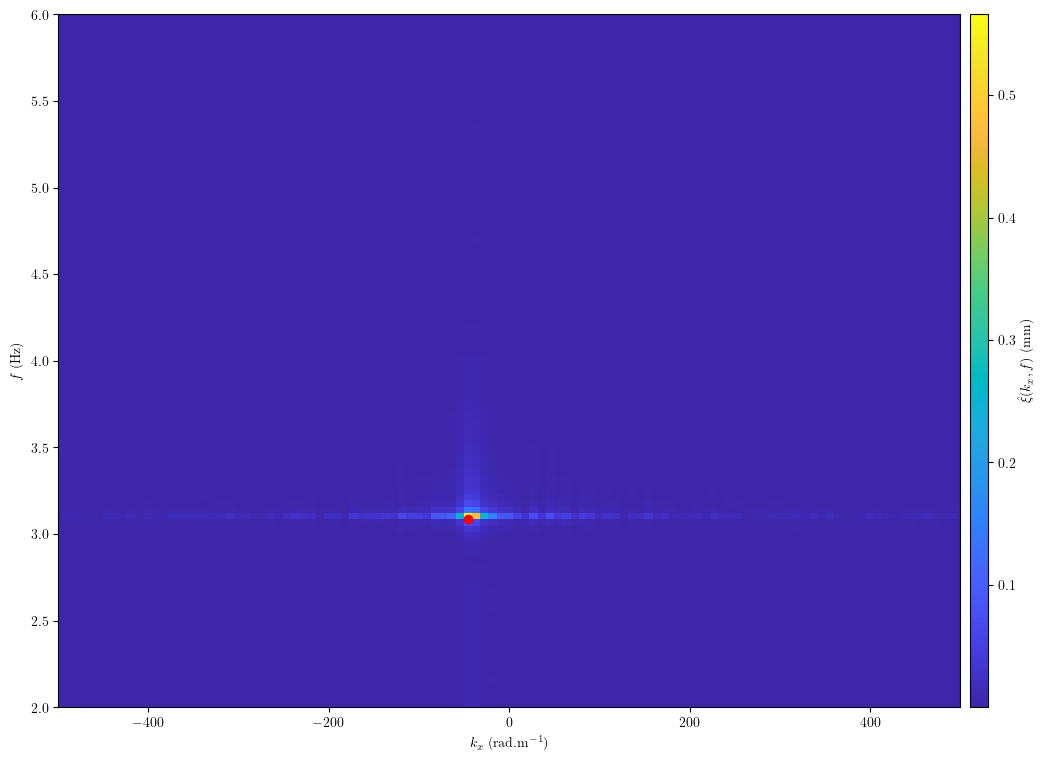

In [151]:
fig, ax = plt.subplots(figsize = (12,9))
c = ax.imshow(abs(positive_shift).T*1e3,cmap = parula_map,aspect = 'auto',norm = 'linear',origin = 'lower',
             extent = (k.min(),k.max(),positive_freq.min(),positive_freq.max()))

ax.set_ylim([2,6])
ax.set_xlim([-500,500])
ax.plot(k[unravel_coords[0]],positive_freq[unravel_coords[1]],'ro')
print(f'f_demod = {positive_freq[unravel_coords[1]]} Hz')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

cbar = plt.colorbar(c,cax = cax)
cbar.set_label(r'$\hat{\xi} (k_x,f) \; \mathrm{(mm)}$',labelpad = 1)

ax.set_xlabel(r'$k_x \; \mathrm{(rad.m^{-1})}$',labelpad = 5)
ax.set_ylabel(r'$f \; \mathrm{(Hz)}$',labelpad = 5)

### Fit by a lorentzian over wavenumbers

(-500.0, 500.0)

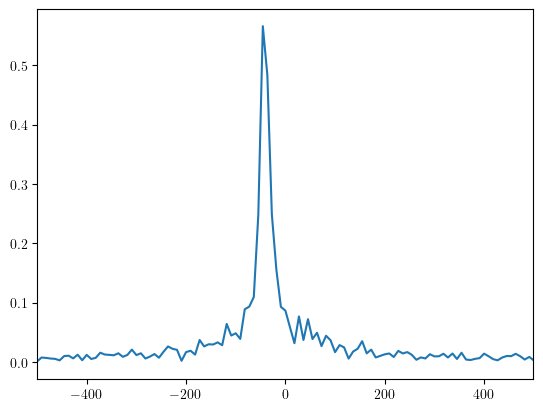

In [148]:
cut = abs(positive_shift)[:,unravel_coords[1]]

fig, ax = plt.subplots()
ax.plot(k,cut*1e3)
ax.set_xlim([-500,500])

In [149]:
y_exp = (cut - cut.min())/(cut.max() - cut.min())

bounds_alpha = (0,1e2)
k0_idx = unravel_coords[0]
bounds_kx0 = (k[k0_idx - 10],k[k0_idx + 10])
bounds_curvefit = ([bounds_kx0[0],bounds_alpha[0]],[bounds_kx0[1],bounds_alpha[1]])
# fit by a lorentzian
popt,pcov = scipy.optimize.curve_fit(lambda x,x0,sigma : lorentzian(x, x0, sigma),k,y_exp,
                                     bounds = bounds_curvefit)
err_coeff = np.sqrt(np.diag(pcov))

$\alpha = 6.6\; \mathrm{(m^{-1})}$


(-1000.0, 1000.0)

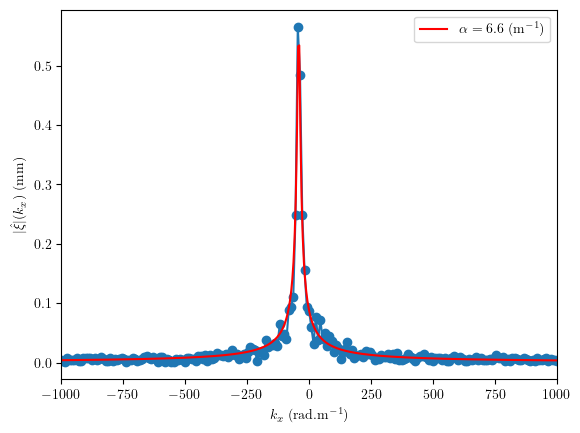

In [150]:
label_fit = r'$\alpha = ' + f'{popt[1]:.1f}' + '\; \mathrm{(m^{-1})}$'
print(label_fit)
k_fit = np.linspace(k.min(),k.max(),4000)
yth = lorentzian(k_fit,popt[0],popt[1])*(cut.max() - cut.min()) + cut.min()

fig, ax = plt.subplots()
ax.plot(k,cut*1e3,'o-')
ax.plot(k_fit,yth*1e3,'r',label = label_fit)
ax.legend()

ax.set_xlabel(r'$k_x \; \mathrm{(rad.m^{-1})}$',labelpad = 5)
ax.set_ylabel(r'$|\hat{\xi}|(k_x) \; \mathrm{(mm)}$',labelpad = 5)
ax.set_xlim([-1000,1000])